# Modelos regressivos

O objetivo desse projeto é prever a demanda diária para categorias de produtos do inventário por meio de um modelo regressivo.

Para isso, o projeto é dividido nos seguintes tópicos:

1. Preparação inicial dos dados
2. Preparação da base para modelos regressivos
3. Modelos regressivos
4. Avaliação de modelos
5. Modelo regressivo em produção
6. Conclusão

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn import tree
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [156]:
def regression_results(y_true, y_pred):
    
    mse = metrics.mean_squared_error(y_true, y_pred)
    
    print('RMSE: ', round(np.sqrt(mse),4))

# 1. Preparação inicial dos dados

Primeiramente, é preciso verificar se há dados faltantes ou nulos na base de dados. Não existem valores nulos na base de dados.

Essa análise apenas contará com produtos válidos, ou seja, produtos que não foram cancelados ou detectados como fraude. Para isso, exclui-se os produtos não válidos da base de dados.

A base de dados original está agrupada por id do pedido. Para prever a demanda diária por categoria de produto, agrupa-se a base de dados por data e por categoria de produto. Em seguida, calcula-se a média diária de quantidade, preço, pis/cofins, icms, taxa de substituição e custo líquido por categoria.

Analisando as quantidades pedidas por categorias, percebe-se que algumas categorias possuem poucos produtos pedidos. Portanto, o modelo de previsão será aplicado apenas nas três maiores categorias. Para selecionar o modelo regressivo, os testes serão feitos na categoria com maior quantidade de produtos vendidos.

O próximo tópico vai preparar os dados para rodar modelos regressivos.

In [2]:
df = pd.read_csv('desafio.csv', sep=',')
df.head()

,order_id,code,quantity,price,pis_cofins,icms,tax_substitution,category,liquid_cost,order_status,capture_date,process_date,process_status,source_channel
0,bcb59c839e78b2601374cbad9239ca7b,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,0.0000,191.8416,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-11,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500
1,4e91ee6b95895771dc9ee524e910a902,e6762ba2ffbca07ab6cee7551caeaad5,1,1036.29,95.8568,176.1693,0.0000,4ece547755cba9e7fc14125bc895f31b,542.7065,em rota de entrega,2016-06-11,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500
2,88eb0ac86af1a521c0831298d22dea8b,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,0.0000,191.8416,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-12,2016-06-12,processado,b76eb9b8fc0f17098812da9117d3e500
3,dee418152a36314b4aee6ce9cf94fcbf,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,176.2020,0.0000,4ece547755cba9e7fc14125bc895f31b,542.7065,cancelado,2016-06-13,0000-00-00,captado,b76eb9b8fc0f17098812da9117d3e500
4,1c175bc61b9b659bbf011b2e5e3dcec6,e6762ba2ffbca07ab6cee7551caeaad5,1,976.05,90.2846,0.0000,192.3325,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-13,2016-06-13,processado,b76eb9b8fc0f17098812da9117d3e500


In [3]:
df = pd.read_csv('desafio.csv', sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179149 entries, 0 to 179148
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   order_id          179149 non-null  object 
 1   code              179149 non-null  object 
 2   quantity          179149 non-null  int64  
 3   price             179149 non-null  float64
 4   pis_cofins        179149 non-null  float64
 5   icms              179149 non-null  float64
 6   tax_substitution  179149 non-null  float64
 7   category          179149 non-null  object 
 8   liquid_cost       179149 non-null  float64
 9   order_status      179149 non-null  object 
 10  capture_date      179149 non-null  object 
 11  process_date      179149 non-null  object 
 12  process_status    179149 non-null  object 
 13  source_channel    179149 non-null  object 
dtypes: float64(5), int64(1), object(8)
memory usage: 19.1+ MB


In [4]:
df = pd.read_csv('desafio.csv', sep=',')
df.describe()

,quantity,price,pis_cofins,icms,tax_substitution,liquid_cost
count,179149.000000,179149.000000,179149.000000,179149.000000,179149.000000,179149.000000
mean,1.055278,234.638585,19.525329,25.095547,17.872443,136.034906
std,0.597942,186.638919,17.402820,32.333226,28.125661,83.603243
min,1.000000,1.030000,0.000000,0.000000,0.000000,4.114100
25%,1.000000,149.910000,10.640300,0.000000,0.000000,78.862100
50%,1.000000,194.400000,17.519500,21.492000,0.000000,117.082000
75%,1.000000,309.360000,28.157000,38.880000,30.403000,205.899700
max,100.000000,19993.000000,1849.352500,3598.740000,280.834200,896.681400


In [157]:
df['capture_date'] = pd.to_datetime(df['capture_date'], format="%Y/%m/%d")

In [10]:
df_valido = df[(
                (df.order_status != 'cancelado boleto não pago') & 
                (df.order_status != 'cancelado') &
                (df.order_status != 'solicitação de cancelamento') &
                (df.order_status != 'cancelado dados divergentes') &
                (df.order_status != 'fraude confirmada') &
                (df.order_status != 'cancelado fraude confirmada') &
                (df.order_status != 'cancelado não aprovado') &
                (df.order_status != 'suspeita de fraude')
                )]
df_valido.head()

,order_id,code,quantity,price,pis_cofins,icms,tax_substitution,category,liquid_cost,order_status,capture_date,process_date,process_status,source_channel
0,bcb59c839e78b2601374cbad9239ca7b,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,0.0000,191.8416,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-11,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500
1,4e91ee6b95895771dc9ee524e910a902,e6762ba2ffbca07ab6cee7551caeaad5,1,1036.29,95.8568,176.1693,0.0000,4ece547755cba9e7fc14125bc895f31b,542.7065,em rota de entrega,2016-06-11,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500
2,88eb0ac86af1a521c0831298d22dea8b,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,0.0000,191.8416,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-12,2016-06-12,processado,b76eb9b8fc0f17098812da9117d3e500
4,1c175bc61b9b659bbf011b2e5e3dcec6,e6762ba2ffbca07ab6cee7551caeaad5,1,976.05,90.2846,0.0000,192.3325,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-13,2016-06-13,processado,b76eb9b8fc0f17098812da9117d3e500
5,a8ad36828898fa3f6efeb5bd19c076f2,e6762ba2ffbca07ab6cee7551caeaad5,1,1089.10,100.7418,185.1470,0.0000,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-13,2016-06-13,processado,9d3e0fcbc1f16d80a76026e8f1c26002


In [273]:
df_valido.groupby('category').agg(sum_qtt=('quantity', 'sum'), order_count=('order_id', 'count')).sort_values('sum_qtt', ascending=False).head()

,sum_qtt,order_count
category,,
388128822cef4b4f102ae881e040a64b,138566,132230
9a97178a18aa6333aabdfb21de182b99,16811,15355
90cc5bdd050bcd7cf0d50d079d0fda66,4690,4217
dda10a917a9ea3120e5d299af5105290,1160,846
98f679396a60f117b171ddedfcc3e5ed,304,272


In [161]:
max_cat = df_valido[(df_valido['category'] == '388128822cef4b4f102ae881e040a64b')]
max_cat.head()

,order_id,code,quantity,price,pis_cofins,icms,tax_substitution,category,liquid_cost,order_status,capture_date,process_date,process_status,source_channel
356,2b382c9769a8f6a564089928642c12c6,723f73c85e91fc31d147dfade389d4f9,1,404.91,37.4542,35.6329,0.0,388128822cef4b4f102ae881e040a64b,289.3563,em rota de entrega,2016-06-08,2016-06-09,processado,b76eb9b8fc0f17098812da9117d3e500
357,82134261102be216e336e8e36ea46cdb,723f73c85e91fc31d147dfade389d4f9,1,464.40,42.9570,54.4881,0.0,388128822cef4b4f102ae881e040a64b,289.3563,entrega total,2016-06-08,2016-06-08,processado,b76eb9b8fc0f17098812da9117d3e500
358,5a5b7a1c31f1fd87e8b74656f2822542,723f73c85e91fc31d147dfade389d4f9,1,404.91,37.4542,35.6329,0.0,388128822cef4b4f102ae881e040a64b,289.3563,em rota de entrega,2016-06-08,2016-06-10,processado,b76eb9b8fc0f17098812da9117d3e500
359,02f1253d9a6bd3792e7ac5ff187ff2ef,723f73c85e91fc31d147dfade389d4f9,1,449.90,41.6158,52.7868,0.0,388128822cef4b4f102ae881e040a64b,289.3563,entrega total,2016-06-08,2016-06-08,processado,98defd6ee70dfb1dea416cecdf391f58
360,ca7ae41d48db38b1b2c57f8567bfdfc1,723f73c85e91fc31d147dfade389d4f9,1,449.88,41.6139,0.0000,0.0,388128822cef4b4f102ae881e040a64b,289.3563,entrega total,2016-06-08,2016-06-08,processado,7261d300057219056592010c7bdaf5ee


In [164]:
ts_df = max_cat.groupby('capture_date').agg(mean_qtt=('price', 'mean'), mean_price=('quantity', 'mean'), 
                                       mean_pis=('pis_cofins', 'mean'), mean_icms=('icms', 'mean'),
                                       mean_tax=('tax_substitution', 'mean'), mean_lcost=('liquid_cost', 'mean'))
                                       
ts_df.head()

,mean_qtt,mean_price,mean_pis,mean_icms,mean_tax,mean_lcost
capture_date,,,,,,
2016-06-01,270.062275,1.015873,24.980768,29.589665,18.711901,144.393844
2016-06-02,295.690674,1.082902,27.351391,28.630523,24.450794,151.919233
2016-06-03,242.440630,1.015748,22.425762,22.564564,20.713281,138.287498
2016-06-04,253.820508,1.067797,23.478408,21.436694,24.842447,143.317076
2016-06-05,273.093927,1.026178,25.261195,23.015852,26.811114,154.787212


# 2. Preparação da base para modelos regressivos

A fim de preparar os dados para rodar os modelos regressivos, é preciso dividir a base de dados em dados de treino (aqui, 80% da base) e dados de teste (20% dos dados).

A visualização gráfica dos dados de treino apresenta alguns indícios sobre a base de dados. Os histogramas mostram que as variáveis estão em diferentes escalas e os bloxplots mostram que a base de dados contém outliers, o que indica que será necessário realizar algum método de feature scaling que não seja sensível a outliers. Os métodos de scaling servem para impedir que uma variável que naturalmente possui números maiores que outra tenha sua influência artificialmente aumentada no modelo, enviesando as previsões.

Como método de scaling que reage bem a outliers, aqui seleciona-se o robust scaler. O robust scaler usa a distância interquartil dos dados para criar a escala padronizada, por isso, os outliers são acomodados sem enviesar a escala da variável. Vale aqui comparar os boxplots antes e depois do scaling, que mostram como as variáveis agora estão com distribuições similares, o que tende a melhorar a acurácia do modelo.

Além disso, a matriz de correlação mostra que algumas variáveis parecem ter correlação positiva umas com as outras, portanto fez-se um teste de multicolinearidade por meio de um mapa de calor e do cálculo do fiv (fator inflacionário de variância). O mapa de calor mostra que as variáveis pis e custo líquido possuem forte correlação entre si (0,84) e o fator inflacionário de variância confirma que as duas variáveis são colineares porque tem um valor de 11,83. Como padrão, define-se que um valor FIV>10 já demonstra multicolinearidade. Provavelmente, o custo líquido do produto já inclui o valor do pis/cofins e, por isso, a alta correlação entre as variáveis. Por isso, opta-se aqui por remover a variável pis/cofins do modelo.

Após separar a nova base de dados e promover o scaling, os testes já não apresentam nenhuma multicolinearidade entre as variáveis. Portanto, os modelos de regressão estão prontos para ser rodados.

In [171]:
X = ts_df[['mean_price','mean_pis', 'mean_icms', 'mean_tax', 'mean_lcost']]
y = ts_df[['mean_qtt']]

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(292, 5)
(292, 1)
(74, 5)
(74, 1)


<AxesSubplot:>

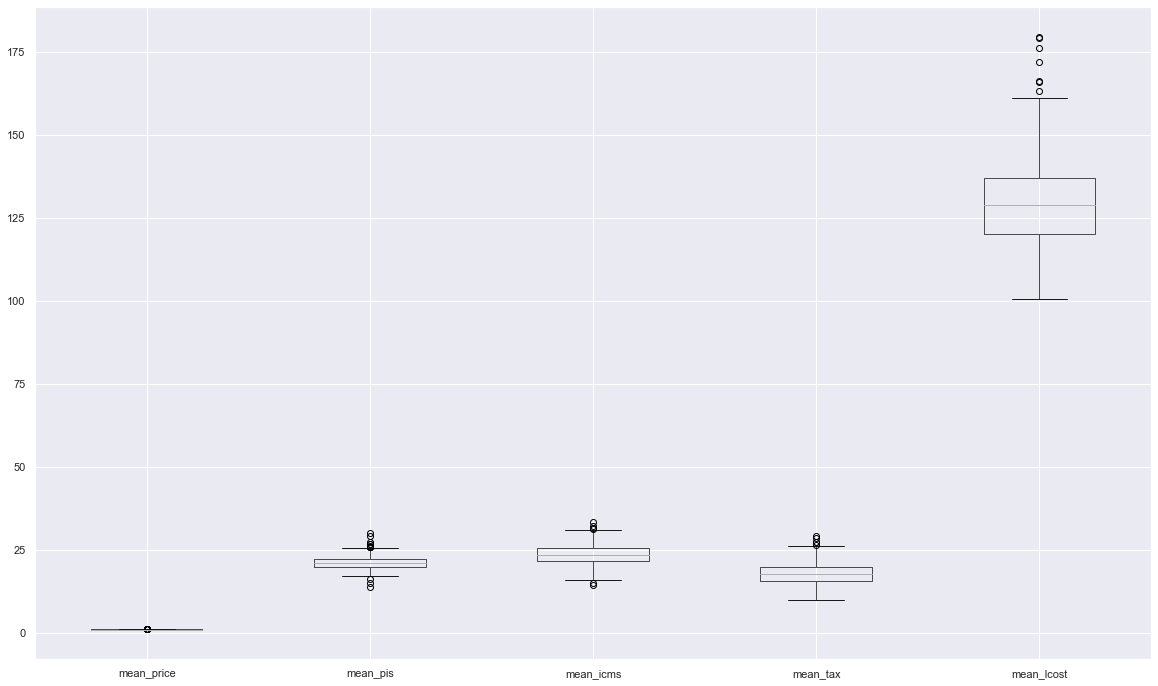

In [173]:
X_train.boxplot()

array([[<AxesSubplot:title={'center':'mean_price'}>,
        <AxesSubplot:title={'center':'mean_pis'}>],
       [<AxesSubplot:title={'center':'mean_icms'}>,
        <AxesSubplot:title={'center':'mean_tax'}>],
       [<AxesSubplot:title={'center':'mean_lcost'}>, <AxesSubplot:>]],
      dtype=object)

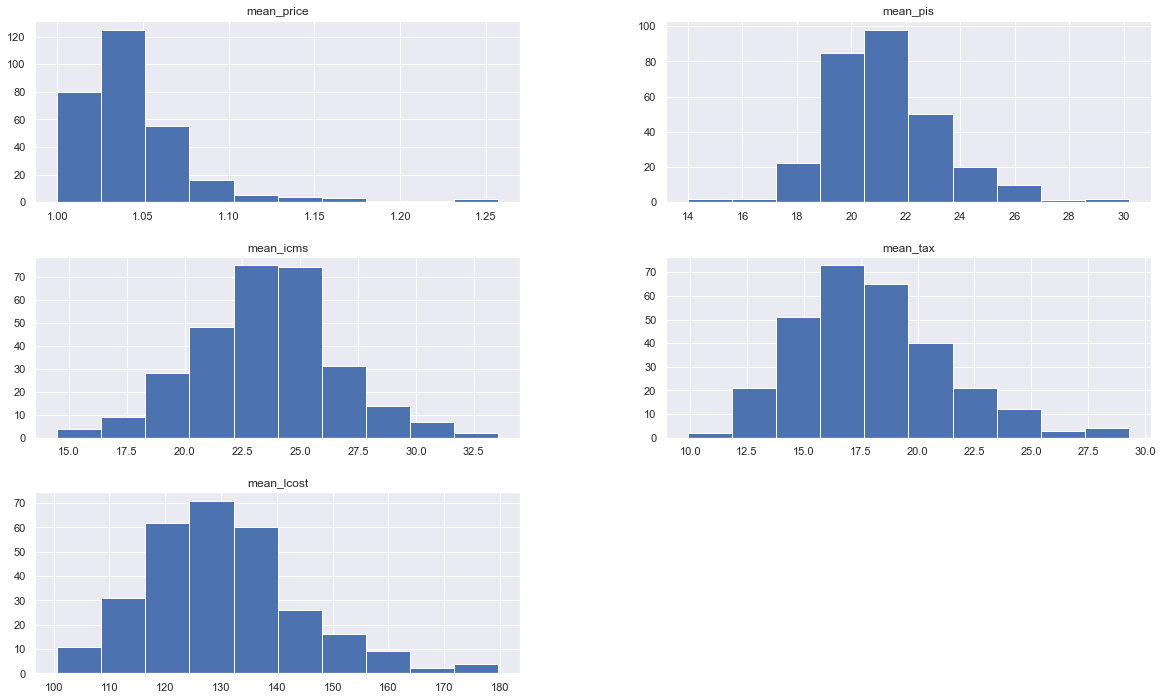

In [174]:
X_train.hist()

# 2.1 Robust scaler

In [179]:
transformer = RobustScaler().fit(X_train)
X_train = transformer.transform(X_train)
X_train = pd.DataFrame(X_train)
X_train.head()

,0,1,2,3,4
0,0.030828,0.167579,0.601505,0.811498,2.787511
1,5.149493,2.489998,1.858024,-0.508951,0.769891
2,-0.039422,-0.275595,0.111692,-0.326313,-0.210566
3,-0.743282,-1.979882,-1.822369,-0.452599,-1.683869
4,0.444597,-0.504387,-0.024840,-0.554605,-0.687004


In [181]:
transformer = RobustScaler().fit(X_test)
X_test = transformer.transform(X_test)
X_test = pd.DataFrame(X_test)

<AxesSubplot:>

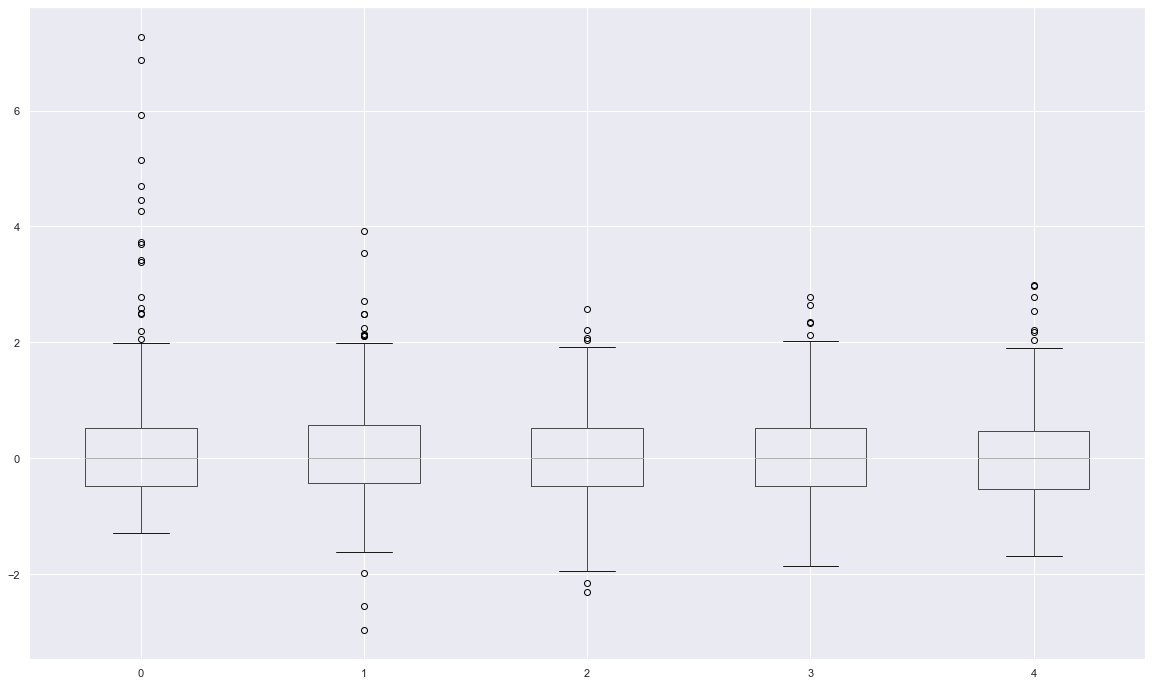

In [182]:
X_train.boxplot()

# 2.2 Multicolinearidade

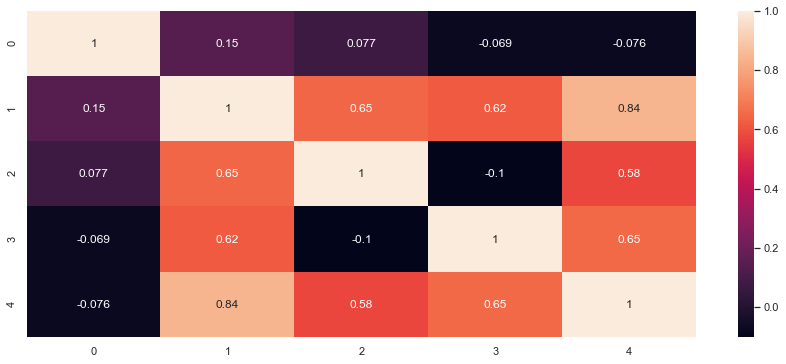

In [183]:
plt.figure(figsize=(15, 6))
sns.heatmap(X_train.corr(), annot=True, cmap='rocket')
plt.show()

In [184]:
vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif

[1.2619826074994733,
 11.836032858734393,
 10.826213721448767,
 11.520000427415408,
 6.918950266304174]

# 2.3 Ajuste de variáveis do modelo

In [186]:
ts_df = max_cat.groupby('capture_date').agg(mean_qtt=('price', 'mean'), mean_price=('quantity', 'mean'), 
                                       mean_icms=('icms', 'mean'),
                                       mean_tax=('tax_substitution', 'mean'), mean_lcost=('liquid_cost', 'mean'))
                                       
ts_df.shape

(366, 5)

In [266]:
X = ts_df[['mean_price', 'mean_icms', 'mean_tax', 'mean_lcost']]
y = ts_df[['mean_qtt']]

In [267]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(292, 4)
(292, 1)
(74, 4)
(74, 1)


In [268]:
transformer = RobustScaler().fit(X_train)
X_train = transformer.transform(X_train)
X_train = pd.DataFrame(X_train)

In [269]:
transformer = RobustScaler().fit(X_test)
X_test = transformer.transform(X_test)
X_test = pd.DataFrame(X_test)

<AxesSubplot:>

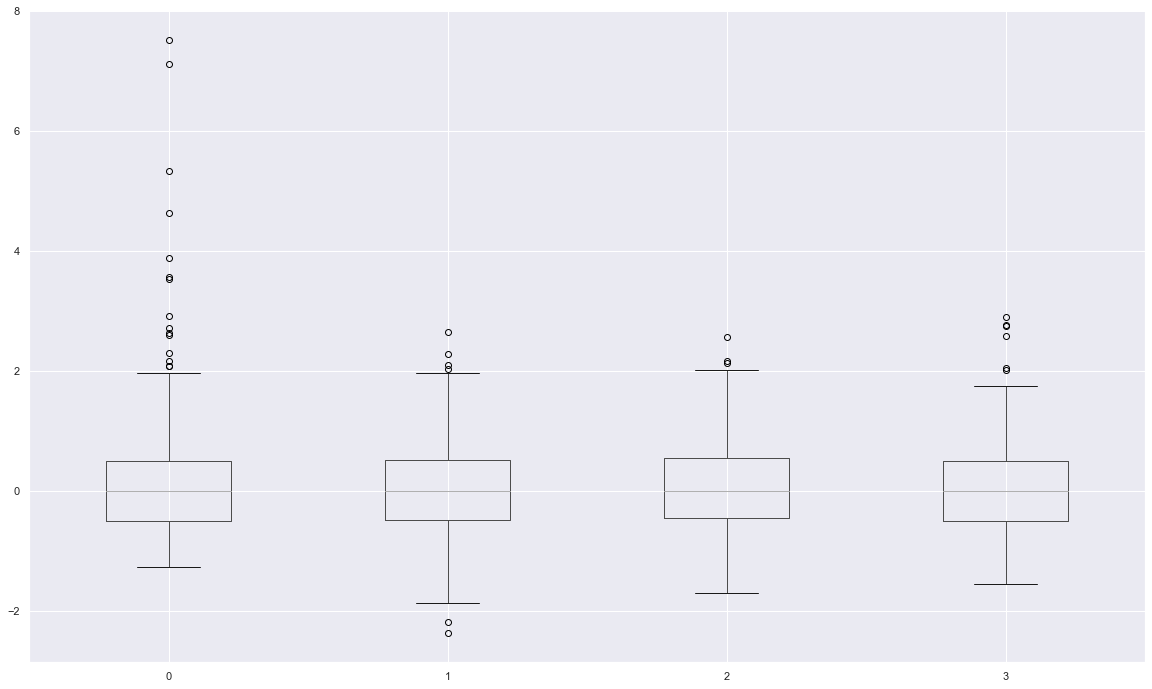

In [190]:
X_train.boxplot()

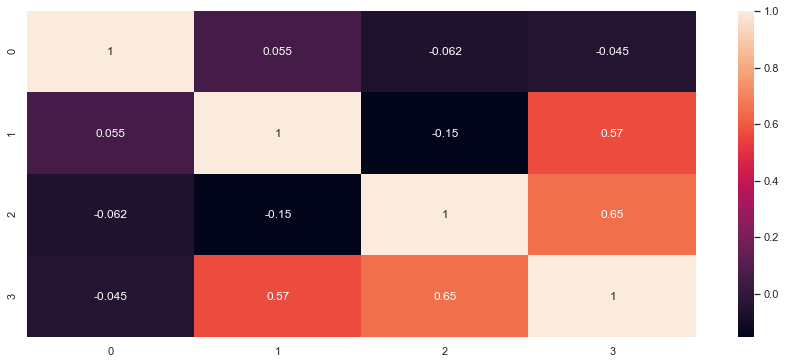

In [191]:
plt.figure(figsize=(15, 6))
sns.heatmap(X_train.corr(), annot=True, cmap='rocket')
plt.show()

In [192]:
vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif

[1.0179142119485125, 5.079823800885385, 6.000697719390516, 8.709903610984627]

array([[<AxesSubplot:xlabel='0', ylabel='0'>,
        <AxesSubplot:xlabel='1', ylabel='0'>,
        <AxesSubplot:xlabel='2', ylabel='0'>,
        <AxesSubplot:xlabel='3', ylabel='0'>],
       [<AxesSubplot:xlabel='0', ylabel='1'>,
        <AxesSubplot:xlabel='1', ylabel='1'>,
        <AxesSubplot:xlabel='2', ylabel='1'>,
        <AxesSubplot:xlabel='3', ylabel='1'>],
       [<AxesSubplot:xlabel='0', ylabel='2'>,
        <AxesSubplot:xlabel='1', ylabel='2'>,
        <AxesSubplot:xlabel='2', ylabel='2'>,
        <AxesSubplot:xlabel='3', ylabel='2'>],
       [<AxesSubplot:xlabel='0', ylabel='3'>,
        <AxesSubplot:xlabel='1', ylabel='3'>,
        <AxesSubplot:xlabel='2', ylabel='3'>,
        <AxesSubplot:xlabel='3', ylabel='3'>]], dtype=object)

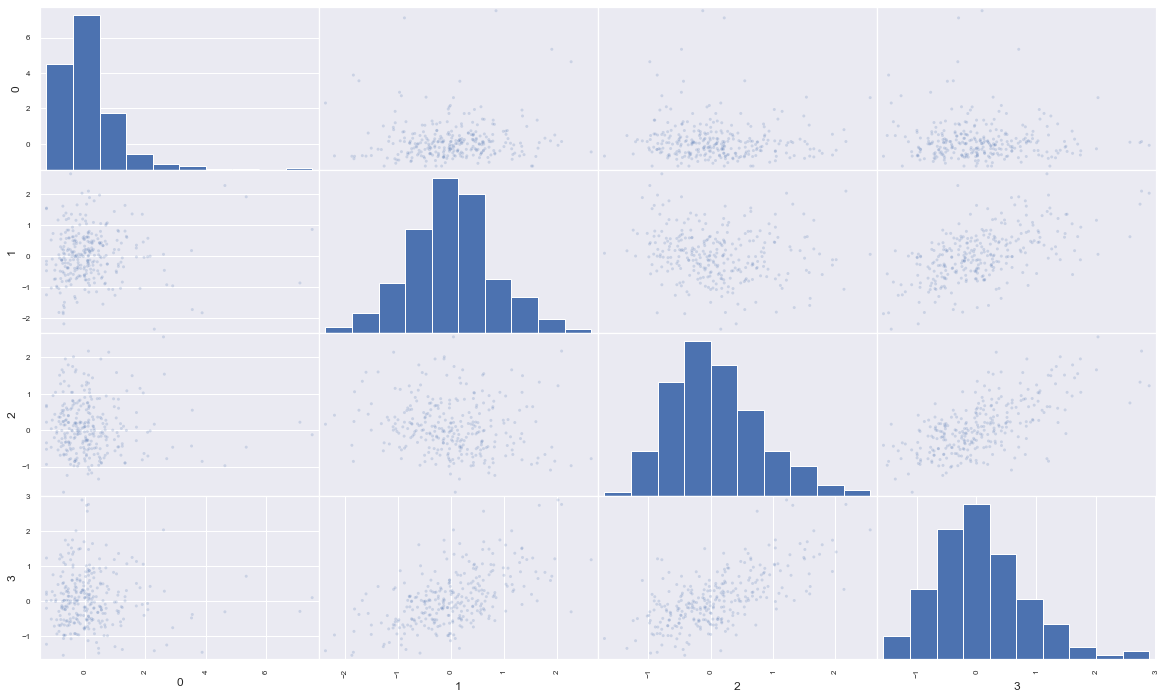

In [193]:
pd.plotting.scatter_matrix(X_train, alpha=0.2)

# 3. Modelos regressivos

Como modelos regressivos, aqui testa-se a regressão linear múltipla e dois modelos diferentes de árvore de decisão (uma tradicional e uma com gradient boosting.

Para cada modelo, optou-se pelo modelo de validação cruzada, que permite que sejam feitos diversos teste com a base de dados de treino para verificar a acurácia do modelo. Como métrica de avaliação dos modelos, compara-se o RMSE. Essa métrica permite que se avalie a acurácia do modelo e penaliza modelos com grandes níveis de erros. Além disso, a métrica está na mesma unidade das variáveis, o que torna o modelo mais explicativo. Quanto menor o RMSE, melhor a performance do modelo.

# 3.1 Regressão linear múltipla

In [240]:
lr = LinearRegression()
lr = lr.fit(X_train, y_train)

In [241]:
scores = cross_val_score(lr, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
scores

array([ -37.96918624,  -66.36309113, -122.75788839,  -41.18926553,
        -38.18631342,  -60.08180179,  -35.86139354,  -40.58253453,
        -25.63243101,  -28.10045711])

In [242]:
lr_rmse = np.sqrt(-scores)
mean_lr_rmse = np.mean(lr_rmse)
std_lr_rmse = np.std(lr_rmse)
scores, mean_lr_rmse, std_lr_rmse

(6.845923874506906, 1.67504106673368)

In [243]:
y_pred_lr = lr.predict(X_test)
regression_results(y_test, y_pred_lr)

RMSE:  9.6428


# 3.2 Árvore de decisão tradicional

In [244]:
regr_tree = tree.DecisionTreeRegressor()
regr_tree = regr_tree.fit(X_train, y_train)

In [245]:
scores = cross_val_score(regr_tree, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
scores

array([-224.13817839, -164.99740215,  -90.72918466, -181.85991306,
       -176.53043592,  -84.62347291, -112.03131212, -166.40503321,
        -92.62949228, -134.20438382])

In [246]:
regr_tree_rmse = np.sqrt(-scores)
mean_regr_tree_rmse = np.mean(regr_tree_rmse)
std_regr_tree_rmse = np.std(regr_tree_rmse)
mean_regr_tree_rmse, std_regr_tree_rmse

(11.800606060576268, 1.886949245585064)

In [247]:
y_pred_tree = regr_tree.predict(X_test)
regression_results(y_test, y_pred_tree)

RMSE:  17.4775


In [248]:
regr_tree.feature_importances_

array([0.08030728, 0.049058  , 0.03584475, 0.83478997])

# 3.3 Árvore de decisão com XGBoost

In [250]:
regr_xgb = xgb.XGBRegressor(max_depth = 5)
regr_xgb = regr_xgb.fit(X_train, y_train)

In [251]:
scores = cross_val_score(regr_xgb, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
scores

array([ -57.95110406,  -70.96583593,  -61.75909587,  -66.97200374,
       -134.88328377,  -73.25419066,  -56.18423593,  -57.50020637,
        -35.38276122,  -34.44691326])

In [252]:
regr_xgb_rmse = np.sqrt(-scores)
mean_regr_xgb_rmse = np.mean(regr_xgb_rmse)
std_regr_xgb_rmse = np.std(regr_xgb_rmse)
mean_regr_xgb_rmse, std_regr_xgb_rmse

(7.914780883925639, 1.5120207150925955)

In [253]:
y_pred_xgb = regr_xgb.predict(X_test)
regression_results(y_test, y_pred_xgb)

RMSE:  12.3345


In [254]:
regr_xgb.feature_importances_

array([0.05756861, 0.11565848, 0.13850906, 0.68826383], dtype=float32)

# 4. Avaliação de modelos

A fim de comparar a performance dos modelos, esse tópico calcula o erro deles e verifica qual alcança o menor RMSE nos dados de treino e na previsão. O modelo com melhor performance é o de regressão linear múltipla. Portanto, esse modelo será aplicado para as três categorias de produtos mais vendidas do inventário.

# 4.1 Regressão linear múltipla

In [257]:
print('média de RMSE: ' + str(mean_lr_rmse) + ' | desvio padrão: ' + str(std_lr_rmse))
regression_results(y_test, y_pred_lr)

média de RMSE: 6.845923874506906 | desvio padrão: 1.67504106673368
RMSE:  9.6428


<AxesSubplot:xlabel='capture_date'>

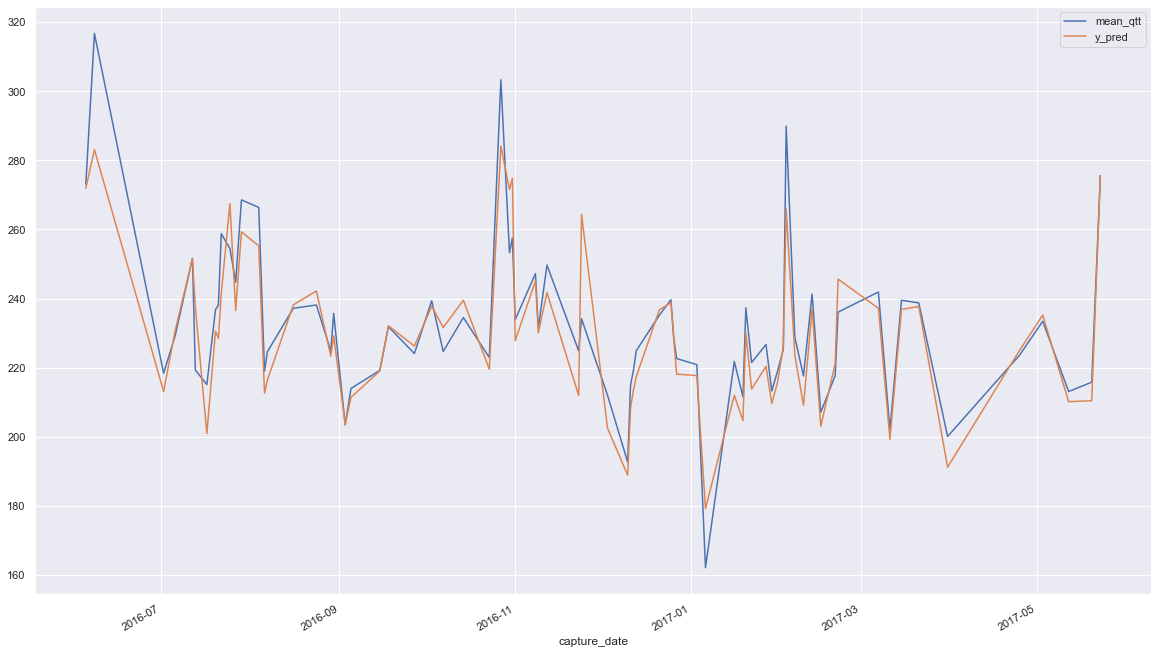

In [258]:
df_lr = pd.DataFrame(y_test)
df_lr['y_pred'] = y_pred_lr
df_lr.plot()

# 4.2 Árvore de decisão tradicional

In [264]:
print('média de RMSE: ' + str(mean_regr_tree_rmse) + ' | desvio padrão: ' + str(std_regr_tree_rmse))
regression_results(y_test, y_pred_tree)

média de RMSE: 11.800606060576268 | desvio padrão: 1.886949245585064
RMSE:  30.0716


<AxesSubplot:xlabel='capture_date'>

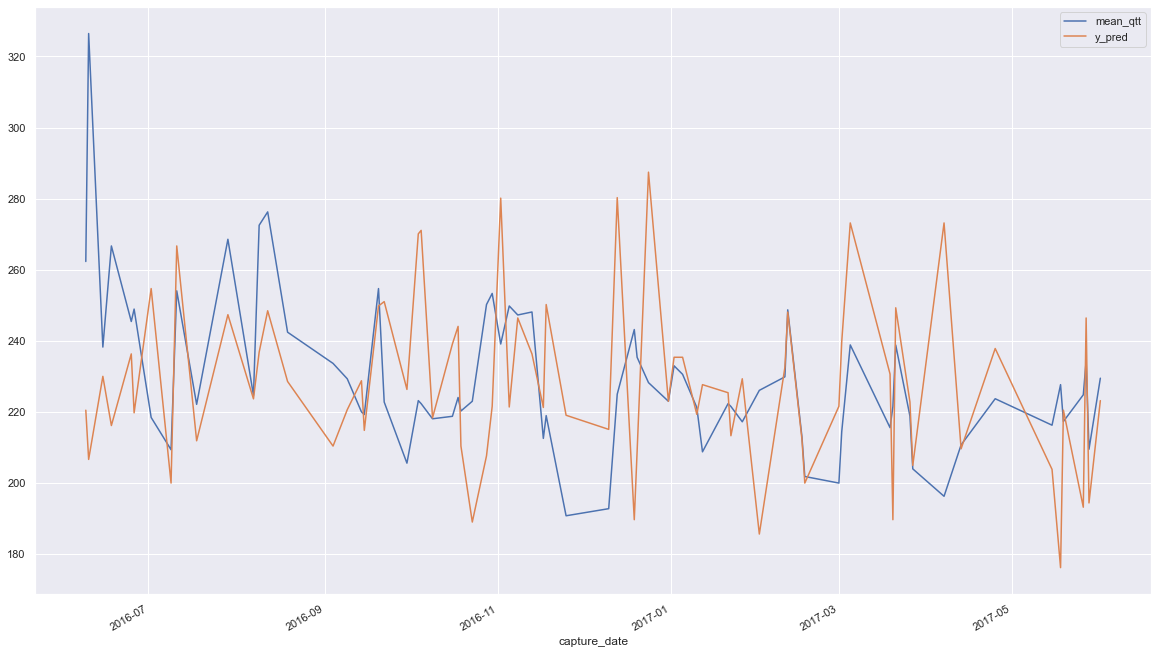

In [265]:
df_tree = pd.DataFrame(y_test)
df_tree['y_pred'] = y_pred_tree
df_tree.plot()

# 4.3 Árvore de decisão com gradient boosting

In [270]:
print('média de RMSE: ' + str(mean_regr_xgb_rmse) + ' | desvio padrão: ' + str(std_regr_xgb_rmse))
regression_results(y_test, y_pred_xgb)

média de RMSE: 7.914780883925639 | desvio padrão: 1.5120207150925955
RMSE:  30.4505


<AxesSubplot:xlabel='capture_date'>

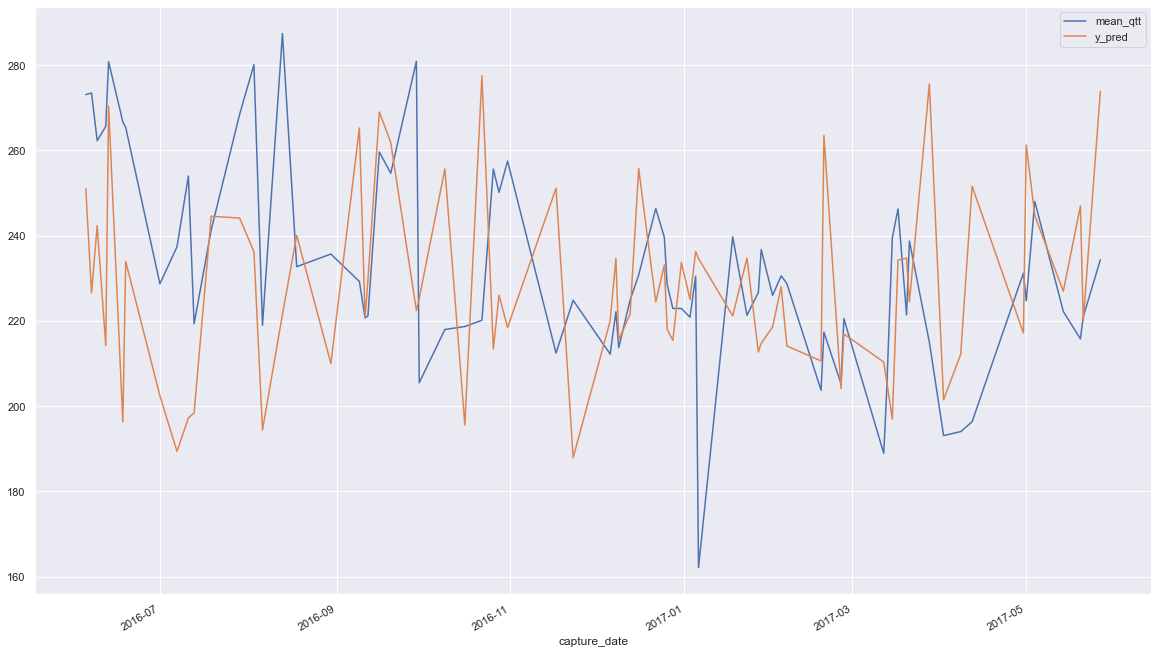

In [271]:
df_xgb = pd.DataFrame(y_test)
df_xgb['y_pred'] = y_pred_xgb
df_xgb.plot()

# 5. Modelo regressivo em produção

Esse tópico aplica o modelo regressivo com melhor performance para as três categorias de produtos mais vendidas do inventário.

Os modelos apresentaram menores índices de erro para as duas primeiras categorias (8,14 e 11,35). Já a terceira categoria mais vendida apresentou um RMSE maior de 84,36 no medo de regressão linear. A diferença na performance do modelo pode ser explicada pelos histogramas das categorias por preço, que mostram que as duas categorias mais vendidas tem números de quantidades vendidas mais próximos e média de preço similares. Assim, a similaridade entre as categorias pode explicar a performance similar dos modelos para as mesmas. Ainda assim, um erro médio de 84 unidades diárias não é tão alto para uma média de 543 unidades diárias vendidas. Portanto, aqui nesse estudo, se mantém esse modelo para a categoria. Porém, seria interessante construir um modelo específico para essa categoria daqui em diante.

# 5.1 Análise exploratória dos dados

In [301]:
cat_df = df_valido[(df_valido['category'] == '388128822cef4b4f102ae881e040a64b') |
        (df_valido['category'] == '9a97178a18aa6333aabdfb21de182b99') |
        (df_valido['category'] == '90cc5bdd050bcd7cf0d50d079d0fda66')]
cat_df.head()

,order_id,code,quantity,price,pis_cofins,icms,tax_substitution,category,liquid_cost,order_status,capture_date,process_date,process_status,source_channel
356,2b382c9769a8f6a564089928642c12c6,723f73c85e91fc31d147dfade389d4f9,1,404.91,37.4542,35.6329,0.0,388128822cef4b4f102ae881e040a64b,289.3563,em rota de entrega,2016-06-08,2016-06-09,processado,b76eb9b8fc0f17098812da9117d3e500
357,82134261102be216e336e8e36ea46cdb,723f73c85e91fc31d147dfade389d4f9,1,464.40,42.9570,54.4881,0.0,388128822cef4b4f102ae881e040a64b,289.3563,entrega total,2016-06-08,2016-06-08,processado,b76eb9b8fc0f17098812da9117d3e500
358,5a5b7a1c31f1fd87e8b74656f2822542,723f73c85e91fc31d147dfade389d4f9,1,404.91,37.4542,35.6329,0.0,388128822cef4b4f102ae881e040a64b,289.3563,em rota de entrega,2016-06-08,2016-06-10,processado,b76eb9b8fc0f17098812da9117d3e500
359,02f1253d9a6bd3792e7ac5ff187ff2ef,723f73c85e91fc31d147dfade389d4f9,1,449.90,41.6158,52.7868,0.0,388128822cef4b4f102ae881e040a64b,289.3563,entrega total,2016-06-08,2016-06-08,processado,98defd6ee70dfb1dea416cecdf391f58
360,ca7ae41d48db38b1b2c57f8567bfdfc1,723f73c85e91fc31d147dfade389d4f9,1,449.88,41.6139,0.0000,0.0,388128822cef4b4f102ae881e040a64b,289.3563,entrega total,2016-06-08,2016-06-08,processado,7261d300057219056592010c7bdaf5ee


array([[<AxesSubplot:title={'center':'388128822cef4b4f102ae881e040a64b'}>,
        <AxesSubplot:title={'center':'90cc5bdd050bcd7cf0d50d079d0fda66'}>],
       [<AxesSubplot:title={'center':'9a97178a18aa6333aabdfb21de182b99'}>,
        <AxesSubplot:>]], dtype=object)

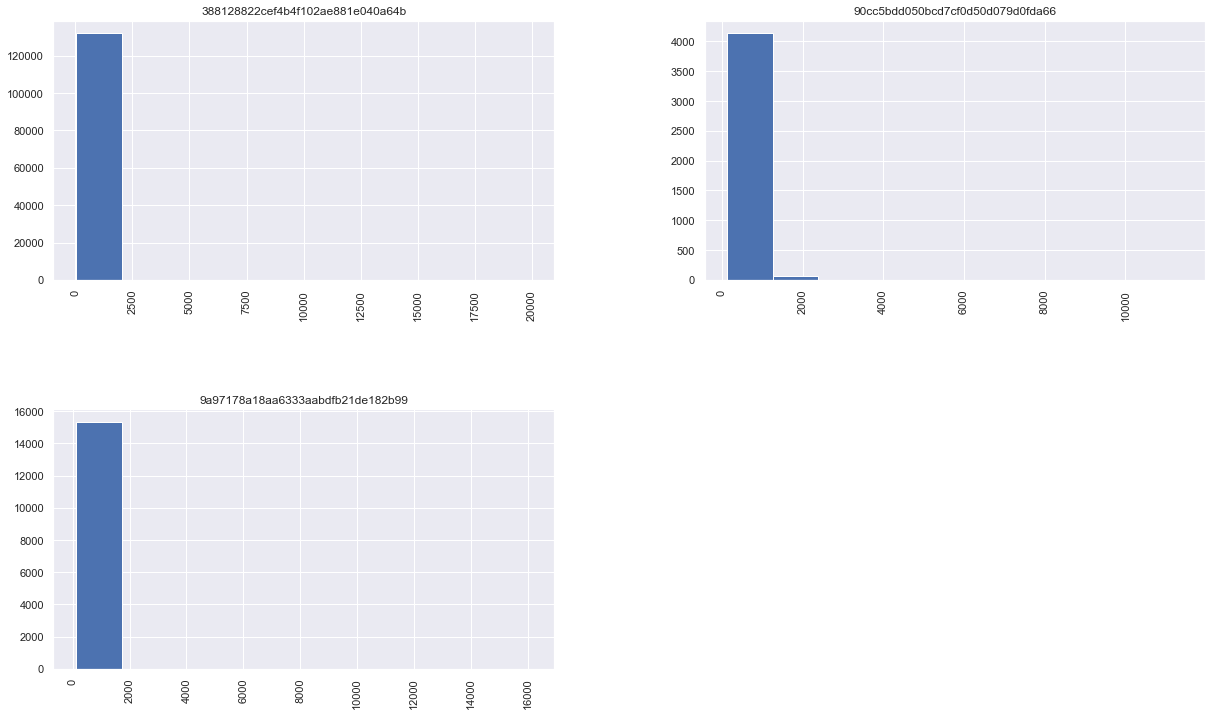

In [302]:
cat_df['price'].hist(by=df['category'])

# 5.2 Preparação da base de dados

In [312]:
df_388 = df_valido[(df_valido['category'] == '388128822cef4b4f102ae881e040a64b')]
df_9a9 = df_valido[(df_valido['category'] == '9a97178a18aa6333aabdfb21de182b99')]
df_90c = df_valido[(df_valido['category'] == '90cc5bdd050bcd7cf0d50d079d0fda66')]

In [313]:
df_388 = df_388.groupby('capture_date').agg(mean_qtt=('price', 'mean'), mean_price=('quantity', 'mean'), 
                                       mean_icms=('icms', 'mean'),
                                       mean_tax=('tax_substitution', 'mean'), mean_lcost=('liquid_cost', 'mean'))

df_9a9 = df_9a9.groupby('capture_date').agg(mean_qtt=('price', 'mean'), mean_price=('quantity', 'mean'), 
                                       mean_icms=('icms', 'mean'),
                                       mean_tax=('tax_substitution', 'mean'), mean_lcost=('liquid_cost', 'mean'))

df_90c = df_90c.groupby('capture_date').agg(mean_qtt=('price', 'mean'), mean_price=('quantity', 'mean'), 
                                       mean_icms=('icms', 'mean'),
                                       mean_tax=('tax_substitution', 'mean'), mean_lcost=('liquid_cost', 'mean'))

df_90c.head()

,mean_qtt,mean_price,mean_icms,mean_tax,mean_lcost
capture_date,,,,,
2016-06-01,388.830000,1.000000,33.2660,44.788233,293.448833
2016-06-02,439.660000,1.000000,34.4616,49.010340,330.915460
2016-06-03,533.598333,1.166667,39.5907,49.580000,342.108533
2016-06-04,208.500000,1.000000,37.5300,0.000000,106.115700
2016-06-05,407.865000,1.000000,17.3196,63.158987,283.110325


# 5.3 Categoria '388128822cef4b4f102ae881e040a64b'

In [288]:
X = df_388[['mean_price', 'mean_icms', 'mean_tax', 'mean_lcost']]
y = df_388[['mean_qtt']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
transformer = RobustScaler().fit(X_train)
X_train = transformer.transform(X_train)
X_train = pd.DataFrame(X_train)
transformer = RobustScaler().fit(X_test)
X_test = transformer.transform(X_test)
X_test = pd.DataFrame(X_test)
lr = LinearRegression()
lr = lr.fit(X_train, y_train)
scores = cross_val_score(lr, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
lr_rmse = np.sqrt(-scores)
mean_lr_rmse = np.mean(lr_rmse)
std_lr_rmse = np.std(lr_rmse)
y_pred_lr = lr.predict(X_test)
print('média de RMSE: ' + str(mean_lr_rmse) + ' | desvio padrão: ' + str(std_lr_rmse))
regression_results(y_test, y_pred_lr)

média de RMSE: 7.272053446928274 | desvio padrão: 2.054234988841324
RMSE:  8.1454


<AxesSubplot:xlabel='capture_date'>

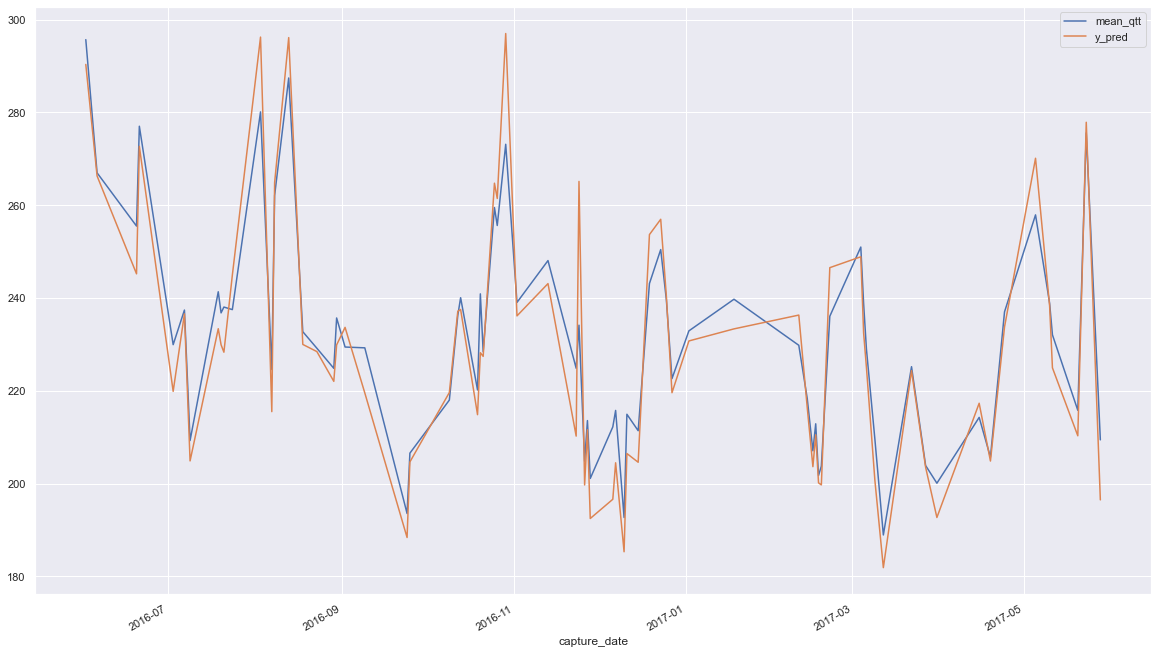

In [289]:
df_lr = pd.DataFrame(y_test)
df_lr['y_pred'] = y_pred_lr
df_lr.plot()

# 5.4 Categoria '9a97178a18aa6333aabdfb21de182b99'

In [290]:
X = df_9a9[['mean_price', 'mean_icms', 'mean_tax', 'mean_lcost']]
y = df_9a9[['mean_qtt']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
transformer = RobustScaler().fit(X_train)
X_train = transformer.transform(X_train)
X_train = pd.DataFrame(X_train)
transformer = RobustScaler().fit(X_test)
X_test = transformer.transform(X_test)
X_test = pd.DataFrame(X_test)
lr = LinearRegression()
lr = lr.fit(X_train, y_train)
scores = cross_val_score(lr, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
lr_rmse = np.sqrt(-scores)
mean_lr_rmse = np.mean(lr_rmse)
std_lr_rmse = np.std(lr_rmse)
y_pred_lr = lr.predict(X_test)
print('média de RMSE: ' + str(mean_lr_rmse) + ' | desvio padrão: ' + str(std_lr_rmse))
regression_results(y_test, y_pred_lr)

média de RMSE: 11.24313165521853 | desvio padrão: 4.927589210965832
RMSE:  11.3517


<AxesSubplot:xlabel='capture_date'>

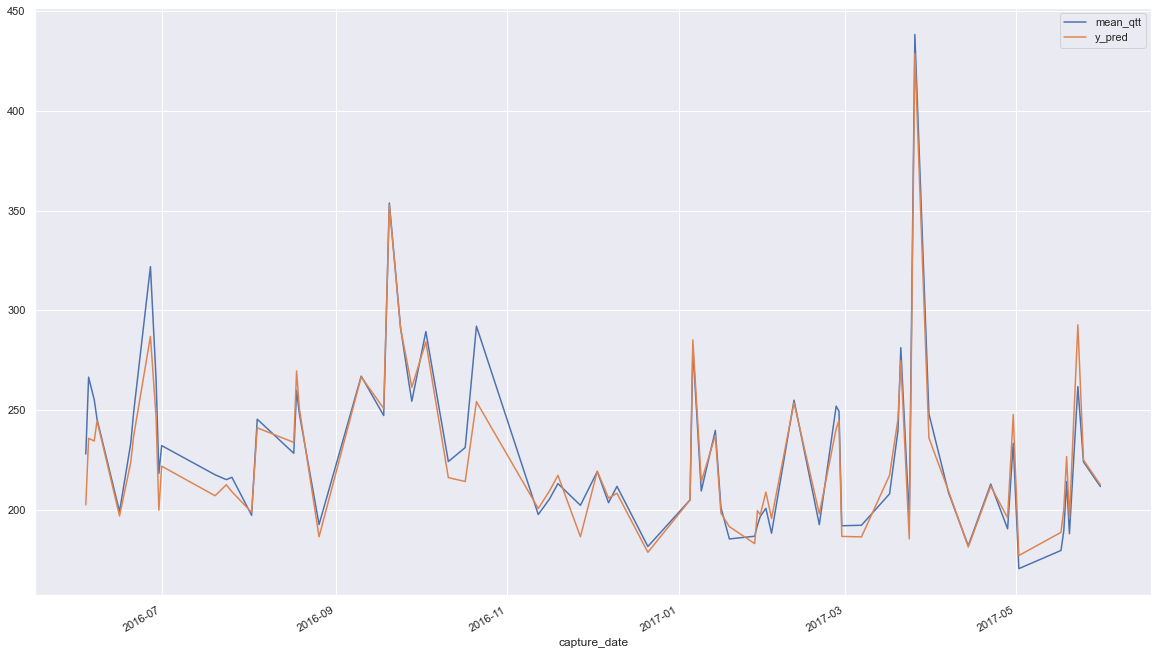

In [291]:
df_lr = pd.DataFrame(y_test)
df_lr['y_pred'] = y_pred_lr
df_lr.plot()

# 5.5 Categoria '90cc5bdd050bcd7cf0d50d079d0fda66'

In [294]:
X = df_90c[['mean_price', 'mean_icms', 'mean_tax', 'mean_lcost']]
y = df_90c[['mean_qtt']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
transformer = RobustScaler().fit(X_train)
X_train = transformer.transform(X_train)
X_train = pd.DataFrame(X_train)
transformer = RobustScaler().fit(X_test)
X_test = transformer.transform(X_test)
X_test = pd.DataFrame(X_test)
lr = LinearRegression()
lr = lr.fit(X_train, y_train)
scores = cross_val_score(lr, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
lr_rmse = np.sqrt(-scores)
mean_lr_rmse = np.mean(lr_rmse)
std_lr_rmse = np.std(lr_rmse)
y_pred_lr = lr.predict(X_test)
print('média de RMSE: ' + str(mean_lr_rmse) + ' | desvio padrão: ' + str(std_lr_rmse))
regression_results(y_test, y_pred_lr)

média de RMSE: 57.55003317984851 | desvio padrão: 23.78161664640553
RMSE:  84.336


<AxesSubplot:xlabel='capture_date'>

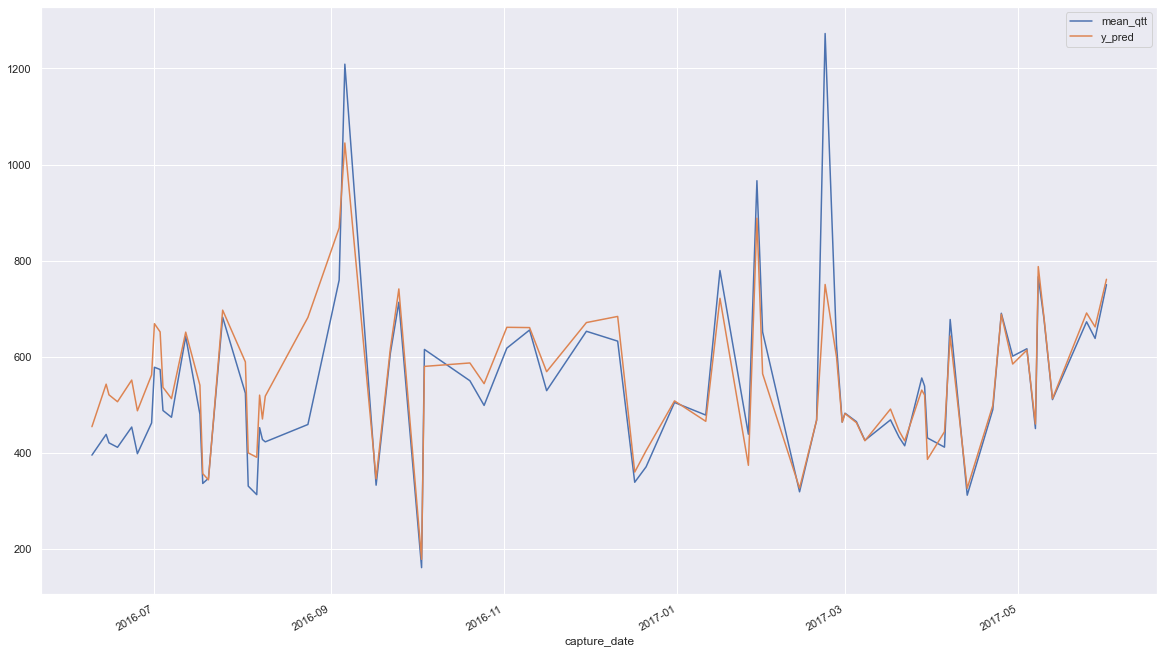

In [295]:
df_lr = pd.DataFrame(y_test)
df_lr['y_pred'] = y_pred_lr
df_lr.plot()

# 6. Conclusão

Esse projeto teve como objetivo criar um modelo regressivo de predição da média de quantidades diárias vendidas para as três categorias que geram maior rendimento no inventário.

O modelo de regressão linear múltipla construído apresentou os menores índices de erro e consegue prever satisfatoriamente a média da demanda diária dessas categorias. Para prever a média de quantidade diária, leva em conta as seguintes variáveis: preço, custo líquido, icms e taxa de substituição.

Para a terceira categoria de produtos mais vendida, é necessário fazer um teste específico para criar um modelo de predição com melhor performance, ainda que esse possa ser usado a curto prazo como modelo preditor.

# 7. Referências

1. MÜLLER, Andreas C.; GUIDO, Sarah. Introduction to Machine Learning with Python: A Guide for Data Scientists. United States of America: O’Reilly Media, 2017.
2. https://aprenderdatascience.com/regressao-polinomial/
3. https://www.atoti.io/when-to-perform-a-feature-scaling/
4. https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35
5. https://medium.com/turing-talks/turing-talks-20-regressão-de-ridge-e-lasso-a0fc467b5629
6. https://www.analyticsvidhya.com/blog/2021/05/complete-guide-to-regularization-techniques-in-machine-learning/
7. https://nathaliatito.medium.com/scikit-learn-ou-statsmodels-avaliando-meu-modelo-de-regressão-f4c04b361fa7
8. https://www.datacamp.com/community/tutorials/xgboost-in-python?utm_source=adwords_ppc&utm_medium=cpc&utm_campaignid=14989519638&utm_adgroupid=127836677279&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=332602034364&utm_targetid=aud-392016246653:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=1001773&gclid=EAIaIQobChMIwpe3sLWO9AIVjYTICh2uEQRuEAAYASAAEgLxmvD_BwE
9. https://www.datageeks.com.br/xgboost/
10. http://arquivo.ufv.br/saeg/saeg70.htm
11. https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205
12. https://quantdare.com/what-is-the-difference-between-bagging-and-boosting/
13. https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b
14. https://medium.com/turing-talks/como-avaliar-seu-modelo-de-regressão-c2c8d73dab96
15. https://towardsdatascience.com/avoid-r-squared-to-judge-regression-model-performance-5c2bc53c8e2e
16. https://www.dataquest.io/blog/learning-curves-machine-learning/
17. https://machinelearningmastery.com/overfitting-machine-learning-models/
18. https://machinelearningmastery.com/training-validation-test-split-and-cross-validation-done-right/
19. https://medium.com/turing-talks/turing-talks-10-introdução-à-predição-a75cd61c268d